# Technical summary figures for BacSC datasets

In [1]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.transforms as mtransforms
import scipy.sparse as sps
from scipy.stats import ranksums, spearmanr, kendalltau
import pickle as pkl
import matplotlib as mpl

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.ClusterDE as cd
import tools.clustering_opt as co

import importlib

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Preprocessing
### Read data

In [3]:
data_path = "../data/MOBA_scRNAseq/outs_S3"
data_gene = sc.read_h5ad(data_path + "/filtered_data_maxpool_processed.h5ad")
data_gene_cluster = sc.read_h5ad(data_path + "/filtered_data_maxpool_processed_cluster.h5ad")

result_path = "P_aero_S2S3/S3_filtered"
with open(result_path + "_scdeed_2/scdeed_rel_scores.pkl", "rb") as f:
    rel_scores = pkl.load(f)
with open(result_path + "_scdeed_2/scdeed_null_rel_scores.pkl", "rb") as f:
    null_rel_scores = pkl.load(f)
with open(result_path + "_scdeed_2/scdeed_reliabilities.pkl", "rb") as f:
    reliabilities = pkl.load(f)
    
mod_df = pd.read_csv(result_path + "_clustering_2/modularities.csv")
mod_df_wide = pd.read_csv(result_path + "_clustering_2/modularities_wide.csv")

data_null_gen = sc.read_h5ad(data_path + "/null_data_opt.h5ad")

figure_path = "technical_figures"
if not os.path.exists(figure_path):
    os.makedirs(figure_path)

### Latent dimensionality

In [4]:
k_opt = data_gene.uns["BacSC_params"]["k_opt"]
n_neighbors_opt = data_gene.uns["BacSC_params"]["n_neighbors_opt"]
min_dist_opt = data_gene.uns["BacSC_params"]["min_dist_opt"]
res_opt = data_gene.uns["BacSC_params"]["res_opt"]

In [5]:
is_overdispersed = False
data_dist = "NB"
data_train, data_test = cs.countsplit_adata(data_gene, data_dist=data_dist, beta_key="nb_overdisp_cutoff", layer="counts", min_genes=1, max_counts=1e9, seed=1234)

# Transformation, centering and PCA
sc.pp.normalize_total(data_train, target_sum=None, layer=None)
if is_overdispersed:
    data_train.X = sps.csr_matrix(np.log(data_train.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
else:
    # data_train.X = sps.csr_matrix(np.sqrt(data_train.X.toarray()))
    data_train.X = sps.csr_matrix(np.log(data_train.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
data_train.layers["vst_counts"] = data_train.X.copy()
sc.pp.scale(data_train, max_value=10, zero_center=True)
sc.tl.pca(data_train, svd_solver='arpack')


sc.pp.normalize_total(data_test, target_sum=None, layer=None)
if is_overdispersed:
    data_test.X = sps.csr_matrix(np.log(data_test.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
else:
    # data_test.X = sps.csr_matrix(np.sqrt(data_test.X.toarray()))
    data_test.X = sps.csr_matrix(np.log(data_test.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
data_test.layers["vst_counts"] = data_test.X.copy()
sc.pp.scale(data_test, max_value=10, zero_center=True)
sc.tl.pca(data_test, svd_solver='arpack')

k_errors, k_opt = cs.select_n_pcs_countsplit(data_train, data_test)
print(f"Optimal number of PCs:{k_opt}")



Optimal number of PCs:3


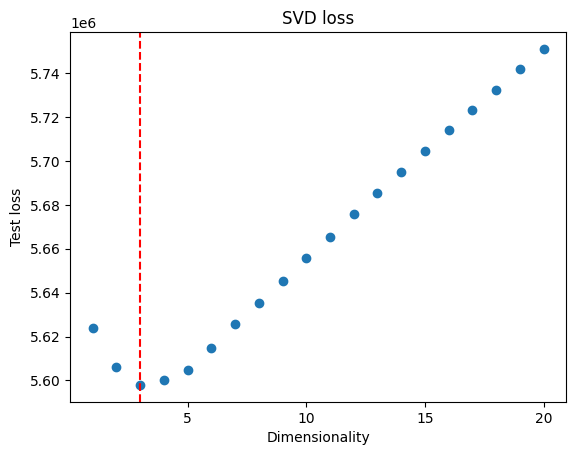

In [6]:
fig, ax = plt.subplots()
ax.scatter(np.arange(20) + 1, k_errors)
ax.set_title("SVD loss")
ax.set(xlabel="Dimensionality", ylabel="Test loss")
ax.set_xticks([5, 10, 15, 20])
plt.axvline(x=k_opt, color="red", linestyle="dashed")
plt.show()

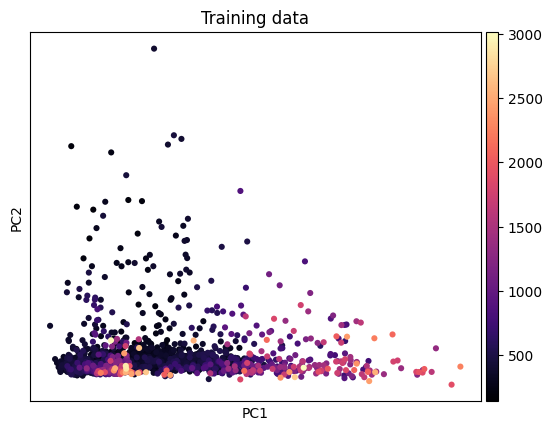

In [7]:
sc.pl.pca(data_train, color="total_counts", cmap="magma", title="Training data")

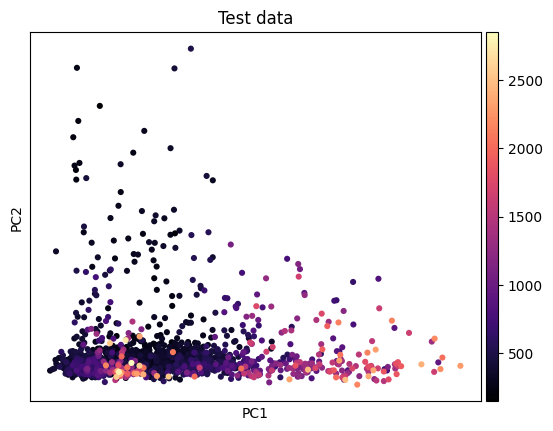

In [8]:
sc.pl.pca(data_test, color="total_counts", cmap="magma", title="Test data")

## scDEED

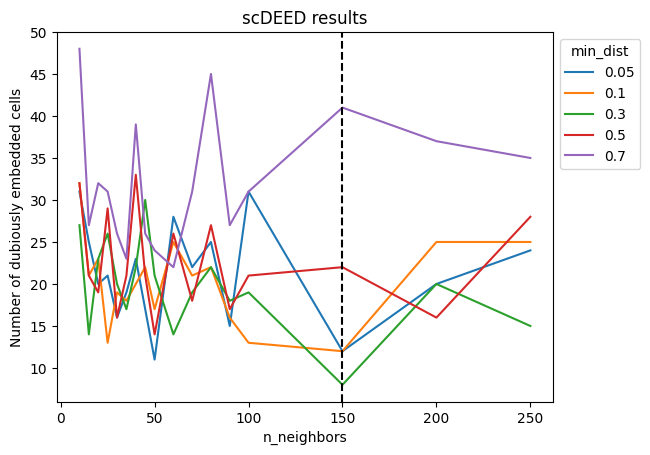

In [9]:
param_df = pd.DataFrame({
    "n_neighbors": [x[0] for x in rel_scores.keys()],
    "min_dist": [x[1] for x in rel_scores.keys()],
    "mean_rel": [np.mean(x) for x in rel_scores.values()],
    "mean_null_rel": [np.mean(x) for x in null_rel_scores.values()],
    "num_dubious": [np.sum([y == "dubious" for y in x]) for x in reliabilities.values()],
    "num_trustworthy": [np.sum([y == "trustworthy" for y in x]) for x in reliabilities.values()],

})
n, p = data_gene.X.shape

param_df["share_dubious"] = param_df["num_dubious"] / n
param_df["share_trustworthy"] = param_df["num_trustworthy"] / n

fig, ax = plt.subplots()
sns.lineplot(data=param_df, x="n_neighbors", y="num_dubious", hue="min_dist", palette="tab10", ax=ax)
ax.set(title="scDEED results", ylabel="Number of dubiously embedded cells")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.legend_.set_title("min_dist")
plt.axvline(x=n_neighbors_opt, color="black", linestyle="dashed")
plt.show()

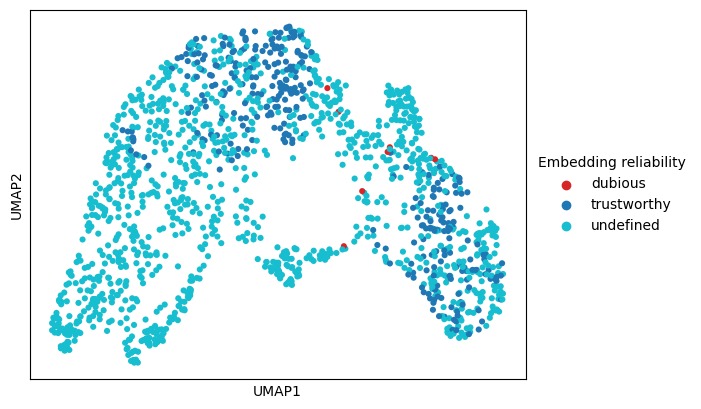

In [ ]:
umap_reliability = sc.pl.umap(data_gene, color="embedding_reliability", alpha=1, title="", show=False, 
                              palette={"undefined": "tab:cyan", "trustworthy": "tab:blue", "dubious": "tab:red"}
                             )
umap_reliability.axes.legend_.set_title("Embedding reliability")
plt.show()

In [ ]:
rel_scores_df = pd.concat((pd.DataFrame({
    "Reliability score": null_rel_scores[n_neighbors_opt, min_dist_opt],
    "Type": "Permuted"
}), pd.DataFrame({
    "Reliability score": rel_scores[n_neighbors_opt, min_dist_opt],
    "Type": "Data"
})))


print(rel_scores_df)
g = sns.histplot(rel_scores_df, x="Reliability score", hue="Type", bins=50)
desc = pd.DataFrame(null_rel_scores[n_neighbors_opt, min_dist_opt]).describe(percentiles=[0.05, 0.95])
print(desc)
for i in ["5%", "95%"]:
    g.axvline(desc.loc[i,0], color="red", linestyle="dashed")
    
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
fig = plt.figure(layout='constrained', figsize=(20, 10))
subfigs = fig.subfigures(2, 3, wspace=0.07, hspace=0.07, width_ratios=[1,1, 1], height_ratios=[1,1])

ax_train = subfigs[0, 0].subplots(1, 1)
sc.pl.pca(data_train, color="total_counts", cmap="magma", title="Training data", ax=ax_train, show=False)
ax_train.figure.axes[1].set_ylabel('Sequencing depth')

ax_test = subfigs[0, 1].subplots(1, 1)
sc.pl.pca(data_test, color="total_counts", cmap="magma", title="Test data", ax=ax_test, show=False)
ax_test.figure.axes[1].set_ylabel('Sequencing depth')

ax_pc = subfigs[0, 2].subplots(1, 1)
ax_pc.scatter(np.arange(20) + 1, k_errors)
ax_pc.set_title("Dimensionality selection (count splitting)")
ax_pc.set(xlabel="Dimensionality", ylabel="Test loss")
ax_pc.set_xticks([5, 10, 15, 20])
plt.axvline(x=k_opt, color="red", linestyle="dashed")

ax_relscore = subfigs[1, 0].subplots(1, 1)
sns.histplot(rel_scores_df, x="Reliability score", hue="Type", bins=50, ax=ax_relscore)
desc = pd.DataFrame(null_rel_scores[n_neighbors_opt, min_dist_opt]).describe(percentiles=[0.05, 0.95])
for i in ["5%", "95%"]:
    ax_relscore.axvline(desc.loc[i,0], color="red", linestyle="dashed")
sns.move_legend(ax_relscore, "upper left", bbox_to_anchor=(1, 1))

ax_scdeed = subfigs[1, 1].subplots(1, 1)
sns.lineplot(data=param_df, x="n_neighbors", y="num_dubious", hue="min_dist", palette="tab10", ax=ax_scdeed)
ax_scdeed.set(title="scDEED results", ylabel="Number of dubiously embedded cells")
sns.move_legend(ax_scdeed, "upper left", bbox_to_anchor=(1, 1))
ax_scdeed.legend_.set_title("min_dist")
ax_scdeed.axvline(x=n_neighbors_opt, color="red", linestyle="dashed")

ax_umap = subfigs[1, 2].subplots(1, 1)
sc.pl.umap(data_gene, color="embedding_reliability", alpha=1, title="", show=False, ax=ax_umap,
           palette={"undefined": "tab:cyan", "trustworthy": "tab:blue", "dubious": "tab:red"})
ax_umap.legend_.set_title("Embedding reliability")

axes = [ax_train, ax_test, ax_pc, ax_relscore, ax_scdeed, ax_umap]
labels = ["A", "B", "C", "D", "E", "F"]

for ax, label in zip(axes, labels):
    if type(ax) == np.ndarray:
        ax = ax[0]
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', va='bottom', fontweight="bold")

plt.savefig(figure_path + "/dim_reduction_supplement.svg", format="svg")
plt.savefig(figure_path + "/dim_reduction_supplement.png", format="png", dpi=300)

plt.show()


## Clustering

In [ ]:
sc.pp.neighbors(data_train, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_train, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1, random_state=1234)

sc.pp.neighbors(data_test, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_test, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1, random_state=1234)


theta_opt, mirror_opt, umap_2_opt, ssd = ut.find_opt_umap_rotation(data_train.obsm["X_umap"].copy(), data_test.obsm["X_umap"].copy())
data_test.obsm["X_umap_rot"] = umap_2_opt

In [ ]:
importlib.reload(co)
res_min = 0.01
res_max = 0.5
res_step = 0.02
resolutions = np.round(np.arange(res_min, res_max, res_step), 2)

co.cluster_train_test(data_train, data_test, resolutions, alg="leiden", random_state=1234)


In [ ]:
fig = plt.figure(layout='constrained', figsize=(20, 15))
subfigs = fig.subfigures(1, 2, wspace=0.07, hspace=0.07, width_ratios=[1.3,1])

ax_umap = subfigs[0].subplots(4, 2)
resolutions_plot = [0.05, 0.15, 0.25, 0.35]
i = 0
for resolution in resolutions_plot:
    umap_train = sc.pl.umap(data_train, color=f"leiden_res{resolution}", ax=ax_umap[i, 0], title=f"Train data, resolution {resolution}", show=False, legend_loc=None)
    umap_test = sc.pl.embedding(data_test, basis="X_umap_rot", color=f"leiden_res{resolution}", ax=ax_umap[i, 1], title=f"Test data, resolution {resolution}", show=False)
    ax_umap[i, 1].set_xlabel("UMAP1")
    ax_umap[i, 1].set_ylabel("UMAP2")
    umap_test.axes.legend_.set_title("Cluster")

    i += 1

ax_other = subfigs[1].subplots(3, 1)

sns.lineplot(data=mod_df, x="resolution", y="score", hue="type", ax=ax_other[0])
ax_other[0].set(title="Clustering modularities", xlabel="Resolution", ylabel="Modularity")
ax_other[0].plot(
    [res_opt, res_opt], 
    [mod_df[(mod_df["resolution"] == res_opt) & (mod_df["type"] == "test")]["score"],
      mod_df[(mod_df["resolution"] == res_opt) & (mod_df["type"] == "random")]["score"]],
    linestyle="dashed", color="black"
)
sns.move_legend(ax_other[0], "upper left", bbox_to_anchor=(1, 1))
ax_other[0].legend_.set_title("Clustering")

sns.lineplot(data=mod_df_wide, x="resolution", y="diff_rand_test", ax=ax_other[1])
ax_other[1].set(xlabel="Resolution", ylabel="Difference Test-Random")

sc.pl.umap(data_gene, color="leiden_opt", show=False, palette="tab10", ax=ax_other[2], title="Whole dataset clustering")
ax_other[2].legend_.set_title("Cluster")

axes = [ax_umap[0,0], ax_other[0], ax_other[1], ax_other[2]]
labels = ["A", "B", "C", "D"]

for ax, label in zip(axes, labels):
    if type(ax) == np.ndarray:
        ax = ax[0]
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', va='bottom', fontweight="bold")

plt.savefig(figure_path + "/clustering_supplement.svg", format="svg")
plt.savefig(figure_path + "/clustering_supplement.png", format="png", dpi=300)

plt.show()

## DE testing figure

In [ ]:
colors = mpl.colormaps['Oranges'](np.linspace(0, 1, 10))
fig = sc.pl.umap(data_gene, color="leiden_opt", palette=[colors[3], "tab:blue", colors[5], colors[7]], title="Bacterial cell types", show=False)
ax = fig.axes
ax.legend_.set_title("Cluster")
plt.tight_layout()
plt.savefig(figure_path + "/clusters_de_test.png", format="png", dpi=300, bbox_inches="tight")

plt.show()

In [ ]:
# Generate scaling matrix
xmin = 1.2262980134308377
cor_orig = cd.schaefer_strimmer(data_gene.layers["counts"].toarray(), use_corr=True)
factor_cor = (np.abs(cor_orig) > 0.1)
cf = factor_cor * xmin
cf[cf == 0] = 1
np.fill_diagonal(cf, 1)
n, p = data_gene.X.shape

data_null_noscale, R_est_noscale = cd.generate_nb_data_copula(data_gene, rng_seed=1234, nb_flavor="statsmod_auto",
                                              auto_dist=True, correct_var=True, return_R=True, corr_factor=1, new_data_shape=(2*n, p),
                                              R_est=None, check_pd=True)
    
data_null_gen, R_est = cd.generate_nb_data_copula(data_gene, rng_seed=5678, nb_flavor="statsmod_auto",
                                                  auto_dist=True, correct_var=True, return_R=True, new_data_shape=(2*n, p),
                                                  corr_factor=cf, R_est=R_est_noscale, check_pd=False, min_nonzero=2)


In [ ]:
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

sc.pp.calculate_qc_metrics(data_null_noscale)
data_null_noscale.var["var_counts"] = np.asarray(np.var(data_null_noscale.X, axis=0)).squeeze()
data_null_noscale.var["mean_counts"] = np.asarray(np.mean(data_null_noscale.X, axis=0)).squeeze()

data_gene_nonzero = data_gene[:, data_null_gen.var_names].copy()
data_gene_nonzero.layers["vst_counts"] = data_gene[:, data_null_gen.var_names].layers["vst_counts"].copy()

In [ ]:
pal = [sns.color_palette("colorblind")[2], sns.color_palette("colorblind")[5]]
pal

In [ ]:
sns.set_theme(style="whitegrid")
mean_df_opt = pd.concat((pd.DataFrame({
    "Gene mean": data_null_gen.var["mean_counts"],
    "Type": "Null data (with correlation scaling)"
}), pd.DataFrame({
    "Gene mean": data_null_noscale.var["mean_counts"],
    "Type": "Null data (no correlation scaling)"
}), pd.DataFrame({
    "Gene mean": data_gene_nonzero.var["mean_counts"],
    "Type": "Original"
})))

g = sns.histplot(mean_df_opt, x="Gene mean", hue="Type", log_scale=True, multiple="dodge", bins=30, shrink=.8, palette=["red", "green", "blue"])
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

plt.show()

mean_df_opt_2 = pd.concat((pd.DataFrame({
    "Null data gene mean": data_null_gen.var["mean_counts"],
    "Type": "With correlation scaling",
    "Original gene mean": data_gene_nonzero.var["mean_counts"]
}), pd.DataFrame({
    "Null data gene mean": data_null_noscale.var["mean_counts"],
    "Type": "No correlation scaling",
    "Original gene mean": data_gene_nonzero.var["mean_counts"]
})))

g = sns.scatterplot(mean_df_opt_2.reset_index(), y="Null data gene mean", x="Original gene mean", hue="Type", palette=pal, alpha=0.5)
g.plot([0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], color="red")
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
sns.set_theme(style="whitegrid")
var_df_opt = pd.concat((pd.DataFrame({
    "Gene variance": data_null_gen.var["var_counts"],
    "Type": "Null data (with correlation scaling)"
}), pd.DataFrame({
    "Gene variance": data_null_noscale.var["var_counts"],
    "Type": "Null data (no correlation scaling)"
}), pd.DataFrame({
    "Gene variance": data_gene_nonzero.var["var_counts"],
    "Type": "Original"
})))

g = sns.histplot(var_df_opt, x="Gene variance", hue="Type", log_scale=True, multiple="dodge", bins=30, shrink=.8, palette="colorblind")
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

plt.show()

var_df_opt_2 = pd.concat((pd.DataFrame({
    "Null data gene variance": data_null_gen.var["var_counts"],
    "Type": "With correlation scaling",
    "Original gene variance": data_gene_nonzero.var["var_counts"]
}), pd.DataFrame({
    "Null data gene variance": data_null_noscale.var["var_counts"],
    "Type": "No correlation scaling",
    "Original gene variance": data_gene_nonzero.var["var_counts"]
})))

g = sns.scatterplot(var_df_opt_2.reset_index(), y="Null data gene variance", x="Original gene variance", hue="Type", palette=pal, alpha=0.5)
g.set(xscale="log", yscale="log")
g.plot([0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], color="red")
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
cor_shrink = cd.schaefer_strimmer(data_gene_nonzero.layers["counts"].toarray(), use_corr=True)
cor_shrink = pd.DataFrame(cor_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

cor_gen_shrink = cd.schaefer_strimmer(data_null_gen.X, use_corr=True)
cor_gen_shrink = pd.DataFrame(cor_gen_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

data_gene_nonzero_2 = data_gene[:, data_null_noscale.var_names].copy()
data_gene_nonzero_2.layers["vst_counts"] = data_gene[:, data_null_noscale.var_names].layers["vst_counts"].copy()
cor_gen_shrink_noscale = cd.schaefer_strimmer(data_null_noscale.X, use_corr=True)
cor_gen_shrink_noscale = pd.DataFrame(cor_gen_shrink_noscale, index=data_gene_nonzero_2.var_names, columns=data_gene_nonzero_2.var_names)

cor_shrink_2 = cd.schaefer_strimmer(data_gene_nonzero_2.layers["counts"].toarray(), use_corr=True)
cor_shrink_2 = pd.DataFrame(cor_shrink, index=data_gene_nonzero_2.var_names, columns=data_gene_nonzero_2.var_names)


# Plot only 100.000 randomly sampled correlations instaed of ~30M
rng = np.random.default_rng(1234)
all_cors = pd.concat((pd.DataFrame({
    "Null data correlation": cor_gen_shrink.values.flatten(),
    "Type": "With correlation scaling",
    "Original data correlation": cor_shrink.values.flatten()
}), pd.DataFrame({
    "Null data correlation": cor_gen_shrink_noscale.values.flatten(),
    "Type": "No correlation scaling",
    "Original data correlation": cor_shrink_2.values.flatten()
})))

ids = rng.choice(pd.unique(all_cors.index), 100000, replace=False)
all_cors_subset = all_cors.loc[ids]

In [ ]:
g = sns.scatterplot(
    all_cors_subset[all_cors_subset['Original data correlation'] < 0.99], 
    x="Original data correlation", y="Null data correlation", hue="Type", palette=pal,
    s=5, alpha=0.5
)
plt.plot([0, np.ceil(np.max(all_cors_subset['Original data correlation']))], [0, np.ceil(np.max(all_cors_subset['Original data correlation']))],
         color="red")
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

plt.show()

In [ ]:
data_null_gen = sc.read_h5ad(data_path + "/null_data_opt.h5ad")


In [ ]:
g = sc.pl.umap(data_null_gen, color=f"leiden_best", alpha=1, title="Null data", show=False)
g.legend_.set_title("Cluster")
plt.show()

In [ ]:
data_gene_cluster.uns

In [ ]:
c = "1"

pvals_log_gen = data_gene_cluster.uns["ClusterDE_results"]

g = sns.histplot(pvals_log_gen[c], x="cs")
g.set_title("Contrast scores")
g.set(xscale="symlog", ylim=(0, 100), xlabel="Contrast score")
plt.show()

g = sns.histplot(pvals_log_gen[c], x="pval_data", bins=100)
g.set_title("Target data p-values")
g.set(xlabel="p-value")
plt.show()

g = sns.histplot(pvals_log_gen[c], x="pval_null", bins=100)
g.set_title("Null data p-values")
g.set(xlabel="p-value")
plt.show()


In [ ]:
fig = plt.figure(layout='constrained', figsize=(10, 15))
sns.set(style="whitegrid", font_scale=0.75)
subfigs = fig.subfigures(4, 2, wspace=0.07, hspace=0.07, width_ratios=[1,1], height_ratios=[1, 1, 1, 1])

ax_umap_data = subfigs[0, 0].subplots(1, 1)
colors = mpl.colormaps['Oranges'](np.linspace(0, 1, 10))
sc.pl.umap(data_gene, color="leiden_opt", palette=[colors[3], "tab:blue", colors[5], colors[7]], title="Bacterial cell types", show=False, ax=ax_umap_data)
ax_umap_data.legend_.set_title("Cluster")

ax_means = subfigs[1, 0].subplots(1, 1)
sns.scatterplot(mean_df_opt_2.reset_index(), y="Null data gene mean", x="Original gene mean", hue="Type", palette=pal, alpha=0.5, ax=ax_means)
ax_means.plot([0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], color="red")
# ax_means.legend([],[], frameon=False)

ax_vars = subfigs[2, 0].subplots(1, 1)
sns.scatterplot(var_df_opt_2.reset_index(), y="Null data gene variance", x="Original gene variance", hue="Type", palette=pal, alpha=0.5, ax=ax_vars)
ax_vars.set(xscale="log", yscale="log")
ax_vars.plot([0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], color="red")
ax_vars.legend([],[], frameon=False)

ax_corrs = subfigs[3, 0].subplots(1, 1)
g = sns.scatterplot(
    all_cors_subset[all_cors_subset['Original data correlation'] < 0.99], 
    x="Original data correlation", y="Null data correlation", hue="Type", palette=pal,
    s=5, alpha=0.5, ax=ax_corrs
)
ax_corrs.plot([0, np.ceil(np.max(all_cors_subset['Original data correlation']))], [0, np.ceil(np.max(all_cors_subset['Original data correlation']))],
         color="red")
ax_corrs.legend([],[], frameon=False)

ax_umap_null = subfigs[0, 1].subplots(1, 1)
sc.pl.umap(data_null_gen, color=f"leiden_best", alpha=1, title="Null data", show=False, ax=ax_umap_null)
ax_umap_null.legend_.set_title("Cluster")

ax_p_data = subfigs[1, 1].subplots(1, 1)
sns.histplot(pvals_log_gen[c], x="pval_data", bins=100, ax=ax_p_data)
ax_p_data.set_title("Target data p-values")
ax_p_data.set(xlabel="p-value")

ax_p_null = subfigs[2, 1].subplots(1, 1)
sns.histplot(pvals_log_gen[c], x="pval_null", bins=100, ax=ax_p_null)
ax_p_null.set_title("Null data p-values")
ax_p_null.set(xlabel="p-value")

ax_cs = subfigs[3, 1].subplots(1, 1)
cs_cutoff = np.min(pvals_log_gen[c][pvals_log_gen[c]["q"] < 0.1]["cs"])
sns.histplot(pvals_log_gen[c], x="cs", ax=ax_cs)
ax_cs.set_title("Contrast scores")
ax_cs.set(xscale="symlog", ylim=(0, 100), xlabel="Contrast score")
ax_cs.axvline(cs_cutoff, color="red", linestyle="dashed")


axes = [ax_umap_data, ax_means, ax_vars, ax_corrs, ax_umap_null, ax_p_data, ax_p_null, ax_cs]
labels = ["A", "B", "C", "D", "E", "F", "G", "H"]

for ax, label in zip(axes, labels):
    if type(ax) == np.ndarray:
        ax = ax[0]
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', va='bottom', fontweight="bold")

plt.savefig(figure_path + "/de_supplement.svg", format="svg")
plt.savefig(figure_path + "/de_supplement.png", format="png", dpi=300)

plt.show()

### DE testing concept figure

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 4))
g = sns.histplot(pvals_log_gen[c], x="pval_data", bins=100)
g.set_title("Target data p-values")
g.set(xlabel="p-value")

plt.savefig(figure_path + "/pvals_orig.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
plt.figure(figsize=(8, 4))
g = sns.histplot(pvals_log_gen[c], x="pval_null", bins=100)
g.set_title("Null data p-values")
g.set(xlabel="p-value")
plt.savefig(figure_path + "/pvals_null.png", format="png", dpi=300, bbox_inches="tight")

plt.show()

In [ ]:
n_genes = 20
clusters = data_gene.obs["leiden_opt"].unique().tolist()
clusters.sort()

plt.figure(figsize=(8, 4))

i = 0
plot_genes = pvals_log_gen[c].iloc[:n_genes,:].index.tolist()
violins = sc.pl.rank_genes_groups_violin(data_gene_cluster, gene_names=plot_genes, key="ClusterDE_results", groups="1", show=False)

i += 1
    
# violins.set(xlabel="Expression", ylabel="Gene", title="")
plt.tight_layout()
plt.savefig(figure_path + "/violin_plots.png", format="png", dpi=300, bbox_inches="tight")

plt.show()

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial import distance

Z = linkage(distance.pdist(cor_shrink), method='average')
Z

In [ ]:
sns.clustermap(cor_shrink, row_linkage=Z, col_linkage=Z, method="average", figsize=(13, 13), cmap="vlag", vmin=-0.4, vmax=0.4)

In [ ]:
sns.clustermap(cor_shrink, row_linkage=Z, col_linkage=Z, method="average", figsize=(13, 13), cmap="vlag", vmin=-0.2, vmax=0.2)

In [ ]:
sns.clustermap(R_est, row_linkage=Z, col_linkage=Z, method="average", figsize=(13, 13), cmap="vlag", vmin=-0.2, vmax=0.2)

In [ ]:
sns.clustermap(cor_gen_shrink, row_linkage=Z, col_linkage=Z, method="average", figsize=(13, 13), cmap="vlag", vmin=-0.2, vmax=0.2)

In [ ]:
cs_cutoff = np.min(pvals_log_gen["1"][pvals_log_gen["1"]["q"] < 0.1]["cs"])
print(cs_cutoff)
plt.figure(figsize=(8, 4))
g = sns.histplot(pvals_log_gen[c], x="cs")
g.set_title("Contrast scores")
g.set(ylim=(0, 30), xlabel="Contrast score")
g.axvline(cs_cutoff, color="red", linestyle="dashed")
plt.savefig(figure_path + "/cs.png", format="png", dpi=300, bbox_inches="tight")

plt.show()

In [ ]:
g = sc.pl.umap(data_null_gen, color=f"leiden_best", alpha=1, title="Null data", show=False)
g.legend_.set_title("Cluster")
plt.savefig(figure_path + "/umap_null.png", format="png", dpi=300, bbox_inches="tight")

plt.show()